In [1]:
from functools import partial
from itertools import chain

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import multivariate_normal as normal
import torch.nn as nn

In [2]:
EPSILON=1e-6
MOMENTUM=0.99
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [3]:
def f(x):
    return np.sin(x)

### We need data! 2000 is not good enough
X=np.atleast_2d(np.random.uniform(0, 2*np.pi, size=10000)).T
X=X.astype(np.float32)

In [4]:
y=f(X).ravel()

In [32]:
#dy =   np.abs(y)*0.5
noise = np.random.normal(0, 1, size=(y.shape))
y = y+ y*noise*0.2
y = y.astype(np.float32)

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
#xx = np.atleast_2d(np.linspace(0, 2*np.pi, 1000)).T


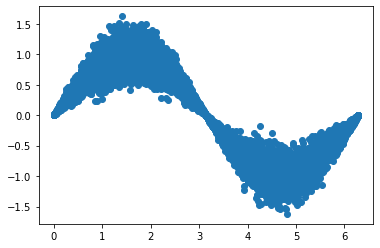

In [33]:
plt.scatter(X,y)

In [34]:
class Config(object):
    Ntime=3 ## There are four snn parts 
    
    dim=64
    
    x_dim=1; 
    y_dim=1; 
    
    logging_frequency = 100
    verbose = True
    y_init_range = [0, 1]
    
    num_hiddens = [dim,256, dim] ## this is for each sub module
    
def get_config(name):
    try:
        return globals()[name]
    except KeyError:
        raise KeyError("config not defined.")

cfg=get_config("Config")

In [35]:
class Dense(nn.Module):
    def __init__(self,cin,cout, batch_norm=False, activate=True): 
        super(Dense, self).__init__()
        self.cin=cin
        self.cout=cout
        self.activate=activate
        self.linear=nn.Linear(self.cin, self.cout)
        
        if batch_norm:
            self.bn=nn.BatchNorm1d(cout,eps=EPSILON,momentum=MOMENTUM)
        else:
            self.bn=None
        
    def forward(self, x):
        x=self.linear(x)
        if self.bn is not None: 
            x=self.bn(x)
        if self.activate:
            x=torch.relu(x)
        return x

class FClayerDrift(nn.Module): 
    def __init__(self,config, batch_norm=False): 
        super(FClayerDrift, self).__init__()

        self.bn=nn.BatchNorm1d(config.num_hiddens[0],eps=EPSILON,momentum=MOMENTUM)

        self.layers=[Dense(config.num_hiddens[i-1],config.num_hiddens[i]) for i in range(1, len(config.num_hiddens)-1)]
        self.layers+=[Dense(config.num_hiddens[-2], config.num_hiddens[-1], activate=False)]
        self.layers=nn.Sequential(*self.layers)
        self.dropout=nn.Dropout(0.1)
             
    def forwardX(self,x):
        x=self.bn(x)
        x=self.layers(x) 
   #     x=self.dropout(x)
        return x   

In [36]:
class Dense2(nn.Module):
    def __init__(self,cin,cout, batch_norm=False, activate=True): 
        super(Dense2, self).__init__()
        self.cin=cin
        self.cout=cout
        self.activate=activate
        self.linear=nn.Linear(self.cin, self.cout)
        self.softplus=nn.Softplus()
        
        if batch_norm:
            self.bn=nn.BatchNorm1d(cout,eps=EPSILON,momentum=MOMENTUM)
        else:
            self.bn=None
        
    def forward(self, x):
        x=self.linear(x)
        if self.bn is not None: 
            x=self.bn(x)
        if self.activate:
            x=torch.relu(x)
        return x

class FClayerDiffusion(nn.Module): 
    def __init__(self,config, batch_norm=False): 
        super(FClayerDiffusion, self).__init__()
        
        self.bn=nn.BatchNorm1d(config.num_hiddens[0],eps=EPSILON,momentum=MOMENTUM)
        self.layers=[Dense2(config.num_hiddens[i-1],config.num_hiddens[i]) for i in range(1, len(config.num_hiddens)-1)]
        self.layers+=[Dense2(config.num_hiddens[-2], config.num_hiddens[-1],activate=False)]
        self.layers=nn.Sequential(*self.layers)
        self.dropout=nn.Dropout(0.1)
             
    def forwardX(self,x):
        x=self.bn(x)
        x=self.layers(x) 
       # x=self.dropout(x)
        return torch.sigmoid(x)

The network consists two bigger list of drift and diffusion parts which should have the same input/output dimensions

We also add another two projection layers at the beginning and the end of the neural network. 

In [37]:
loss_fn = nn.MSELoss(reduction='mean')
class SNN(nn.Module):
    def __init__(self, config, X,y, batch_size): 
        super(SNN, self).__init__()
        self.config=config
        self.X=X
        self.driftList=nn.ModuleList([FClayerDrift(self.config) for _ in range(self.config.Ntime)])
        self.diffusionList=nn.ModuleList([FClayerDiffusion(self.config) for _ in range(self.config.Ntime)])
 
        self.project0=Dense(self.config.x_dim,self.config.dim,activate=False)
        self.project_end=Dense(self.config.dim, self.config.y_dim, activate=False)
        
        self.batch_size=batch_size
        self.h=1.0/self.config.Ntime
        self.sqrth=np.sqrt(self.h)
        self.W_p=[torch.tensor(np.random.normal(0,1, (self.X.shape[0],self.config.dim)),dtype=torch.float32, requires_grad=False).to(device) for i in range(0,self.config.Ntime)]
        self.y=torch.from_numpy(y).unsqueeze(1)

    def forwardX(self,x,idx): 
      #  x=torch.tensor(x,dtype=torch.float32,requires_grad=True)
        xMat=[]
        xMat.append(x)

        x=self.project0(x)
        xMat.append(x)
        for i in range(0,self.config.Ntime):
          x=x+self.driftList[i].forwardX(x)*self.h+self.diffusionList[i].forwardX(x)*self.W_p[i][idx,:]*self.sqrth
          xMat.append(x)

        x=self.project_end(x)
        xMat.append(x)
        return xMat
      
    def backwardYZ(self,xMat,idx): ## target=
        yMat=[]
        zMat=[]

        #try to figure it later
        x_terminal=xMat[-1]
        loss=loss_fn(x_terminal,self.y[idx].to(device))
        #terminal Y_T
        y_terminal=torch.autograd.grad(outputs=[loss],inputs=[x_terminal], grad_outputs=torch.ones_like(loss), 
                                       allow_unused=True,retain_graph=True, create_graph=True)[0]
        yMat.append(y_terminal)
######## Dealing with the last layer ######## 
        xin=xMat[-2]; 
        ## here yMat[-1] is the terminal, self.project_end(xin) is also right
        hami=torch.sum(yMat[-1].detach()*self.project_end(xin),dim=1)
        ytemp=torch.autograd.grad(outputs=[hami],inputs=[xin], grad_outputs=torch.ones_like(hami), 
                                    allow_unused=True,retain_graph=True, create_graph=True)[0]
        yMat.append(ytemp)

####### Dealing with the middle layer
        for i in range(self.config.Ntime-1,-1,-1):
          xin=xMat[i+1]
          ztemp=yMat[-1]*self.W_p[i][idx,:]/self.sqrth #/torch.norm(self.W_p[i][idx,:], dim=1,keepdim=True)#/self.sqrth ### inverse order as well 
          zMat.append(ztemp)

## 4th layer eating x_4 (starting from 0)
          hami=torch.sum(yMat[-1].detach()*self.driftList[i].forwardX(xin)+ztemp.detach()*self.diffusionList[i].forwardX(xin),dim=1)
          ## this part requires analysis
          hami_x=torch.autograd.grad(outputs=[hami],inputs=[xin], grad_outputs=torch.ones_like(hami), 
                                    allow_unused=True,retain_graph=True, create_graph=True)[0]
                            
          ytemp=yMat[-1]+hami_x*self.h
          yMat.append(ytemp)

 ###### This is for the initial projection ######
        xin=xMat[0]
        hami=torch.sum(yMat[-1].detach()*self.project0(xin),dim=1)
        hami_x=torch.autograd.grad(outputs=[hami],inputs=[xin], grad_outputs=torch.ones_like(hami), 
                                    allow_unused=True,retain_graph=True, create_graph=True)[0]
        ytemp=hami_x
        yMat.append(ytemp)
        return yMat, zMat #, xMat

    def Hamcompute(self,xMat,yMat,zMat): 
        total_ham=0.0; 
        ham=torch.sum(yMat[-2].detach()*self.project0(xMat[0].detach())) ## correct
        total_ham+=ham

        for i in range(0,self.config.Ntime): 
          ham=torch.sum(yMat[self.config.Ntime-i].detach()*self.driftList[i].forwardX(xMat[i+1].detach())+zMat[i].detach()*self.diffusionList[i].forwardX(xMat[i+1].detach()))
          total_ham+=ham

        ham=torch.sum(yMat[0].detach()*self.project_end(xMat[-2].detach()))
        total_ham+=ham
        return total_ham/self.batch_size

    def predict(self,X):
        xx=X.clone()
        xMat=[]
        x=self.project0(xx)
        xMat.append(x)
        for i in range(0,self.config.Ntime):
          x=x+self.driftList[i].forwardX(x)*self.h+self.diffusionList[i].forwardX(x)*torch.FloatTensor(normal.rvs(size=[x.shape[0],self.config.dim])).to(device)*self.sqrth
          xMat.append(x)

        x=self.project_end(x)
        xMat.append(x)
        return xMat[-1]

    def predict_train(self,X):
        xx=X.clone()
        xMat=[]
        x=self.project0(xx)
        x=self.project0(X)
        for i in range(0,self.config.Ntime):
          x=x+self.driftList[i].forwardX(x)*self.h+self.diffusionList[i].forwardX(x)*self.W_p[i]*self.sqrth

        x=self.project_end(x)
        return x


In [38]:
device

'cuda'

In [45]:
batch_size=1024
model=SNN(cfg,X,y,batch_size).to(device);
epoch=100000; 
from torch.optim.lr_scheduler import MultiStepLR
## We see that we N=3 is kinda okay 
optimizer=torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-8) #1e-3 too fast. use 3e-8 as decay for N=3
scheduler = MultiStepLR(optimizer, milestones=[40000,  70000], gamma=0.4) # 0.4 may be a good choice
#scheduler = MultiStepLR(optimizer, milestones=[35000, 70000], gamma=0.1)


loss_history=[]
grad_clip=0.1

In [46]:
X=torch.tensor(X,requires_grad=True)

<ipython-input-46-6297a68381d6>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X=torch.tensor(X,requires_grad=True)


Epoch 1000: -2.8293856303207576e-05


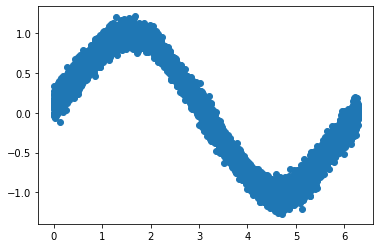

Epoch 2000: -0.0001751977251842618


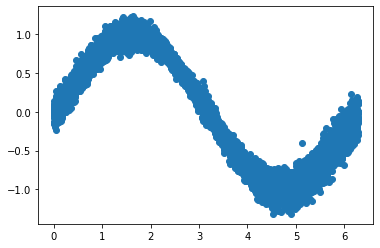

Epoch 3000: -7.63738207751885e-05


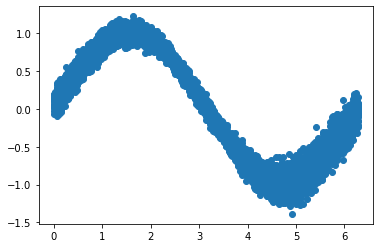

Epoch 4000: 5.489096656674519e-05


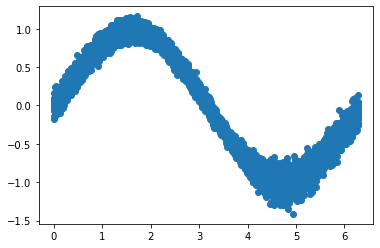

Epoch 5000: 4.132424692215864e-06


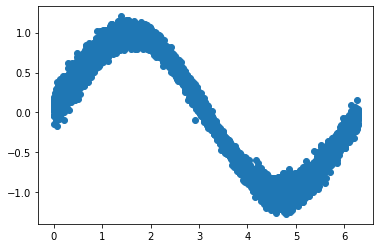

Epoch 6000: 5.634775334328879e-06


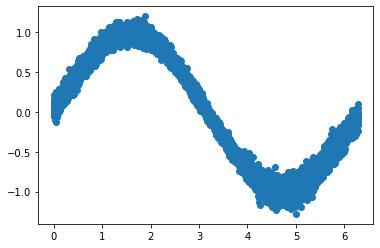

Epoch 7000: -7.808655936969444e-06


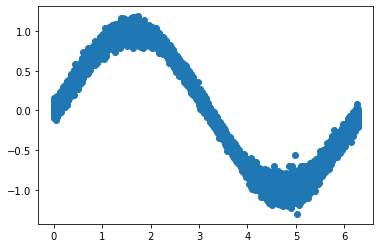

Epoch 8000: -9.68960375757888e-06


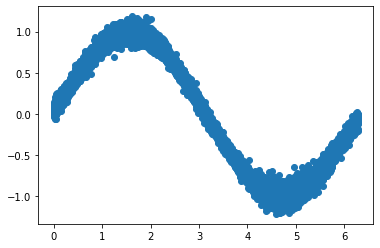

Epoch 9000: -2.635723285493441e-05


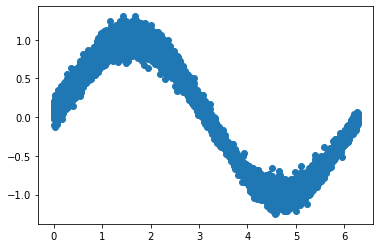

Epoch 10000: -0.00011544818698894233


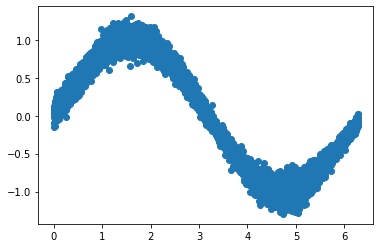

Epoch 11000: -3.971251135226339e-05


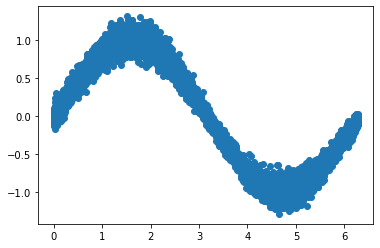

Epoch 12000: -0.00010074085730593652


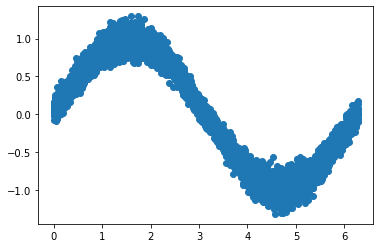

Epoch 13000: -9.887696069199592e-05


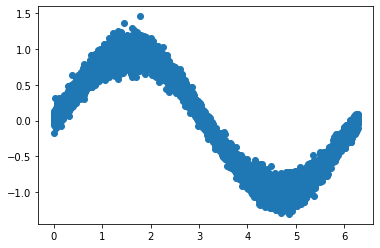

Epoch 14000: -8.658751903567463e-05


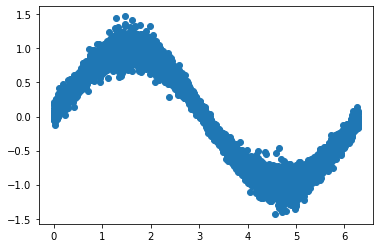

Epoch 15000: -7.285534229595214e-05


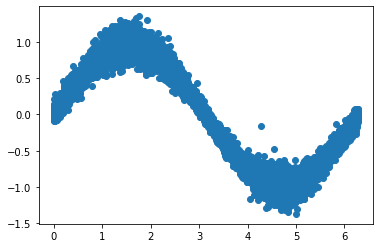

Epoch 16000: -0.00015797569358255714


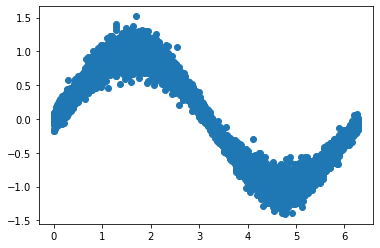

Epoch 17000: -8.317034371430054e-05


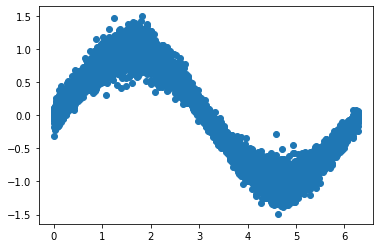

Epoch 18000: -0.00010847653902601451


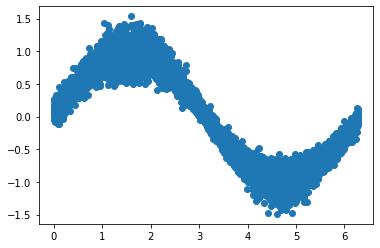

Epoch 19000: -0.0001364461495541036


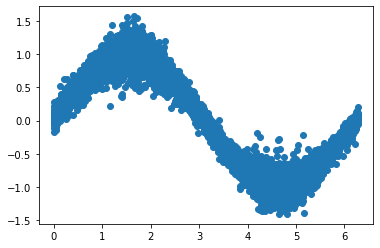

Epoch 20000: -0.00017212115926668048


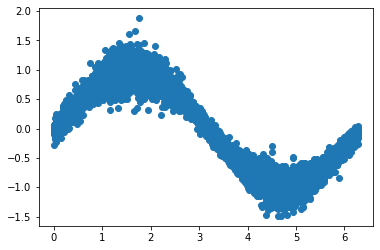

Epoch 21000: -0.00015249654825311154


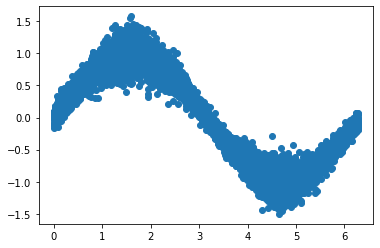

Epoch 22000: -0.0003968662931583822


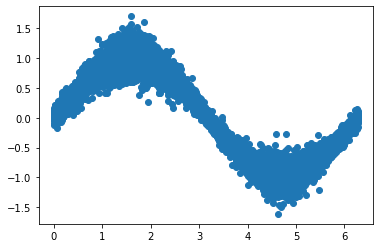

Epoch 23000: -0.00031498083262704313


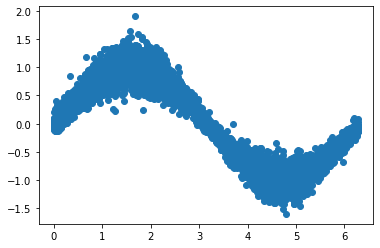

Epoch 24000: 1.5154237189562991e-05


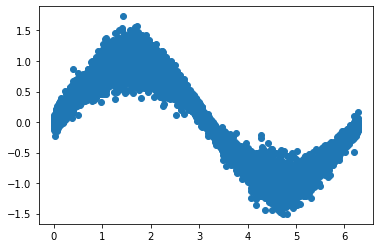

Epoch 25000: -0.0002210352395195514


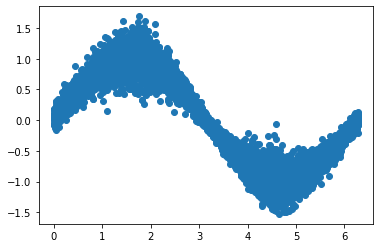

Epoch 26000: -0.00016799484728835523


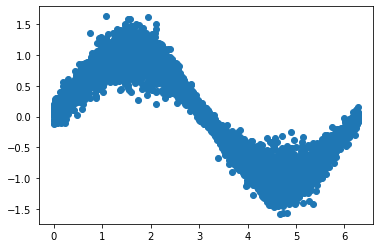

Epoch 27000: -2.711400156840682e-05


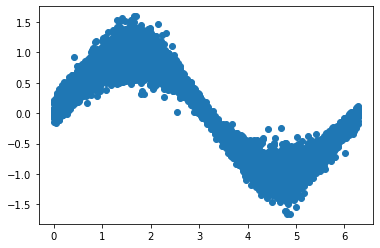

Epoch 28000: -0.00016975404287222773


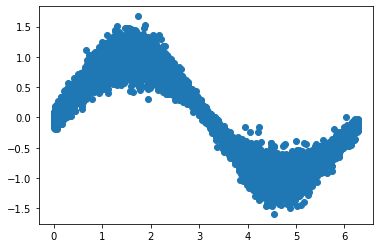

Epoch 29000: -0.0004069845308549702


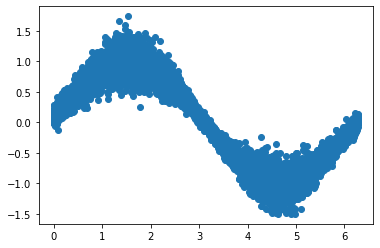

Epoch 30000: -0.0002519342233426869


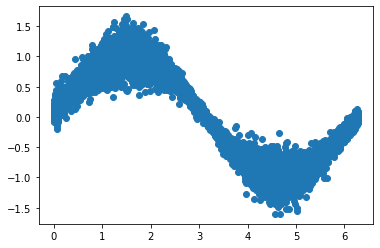

Epoch 31000: -0.00021333097538445145


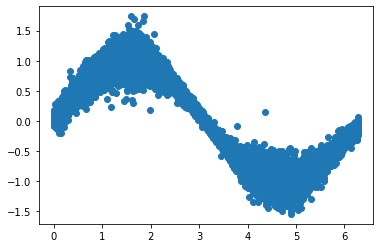

Epoch 32000: -0.0004280298016965389


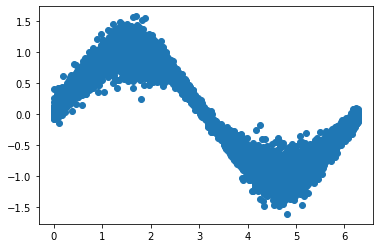

Epoch 33000: -0.0004337916034273803


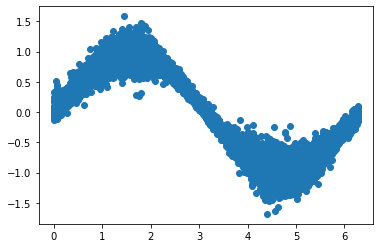

Epoch 34000: -0.00041228136979043484


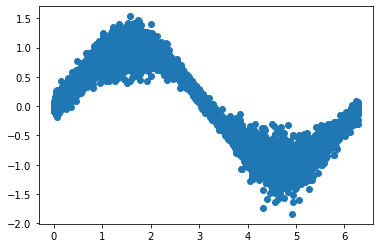

Epoch 35000: -0.0006066755740903318


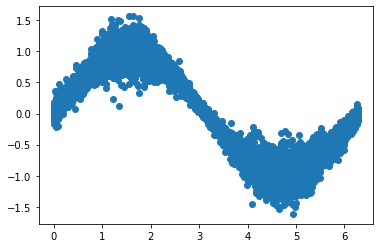

Epoch 36000: -0.0006142342463135719


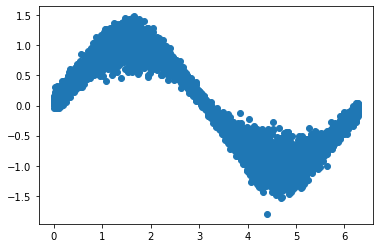

Epoch 37000: -0.0003801874117925763


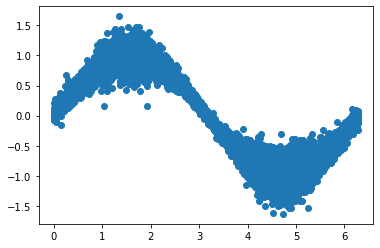

Epoch 38000: -0.00041833423892967403


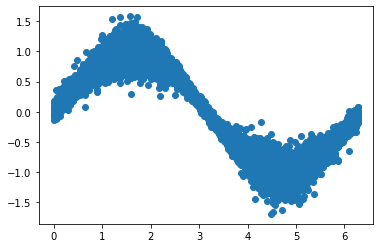

Epoch 39000: -0.0006630184361711144


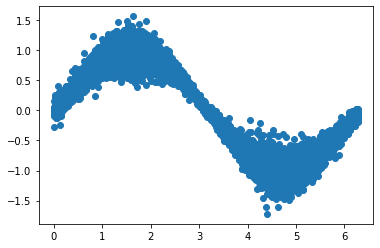

Epoch 40000: -0.0007593123009428382


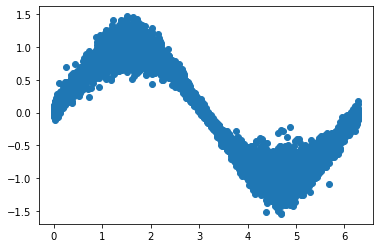

Epoch 41000: -0.0008189741638489068


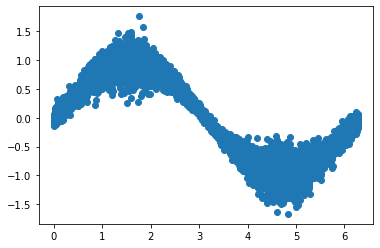

Epoch 42000: -0.0005191688542254269


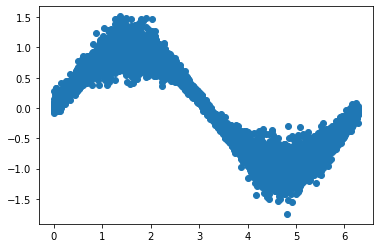

Epoch 43000: -0.0008116831304505467


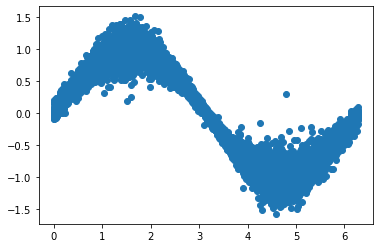

Epoch 44000: -0.0009413874940946698


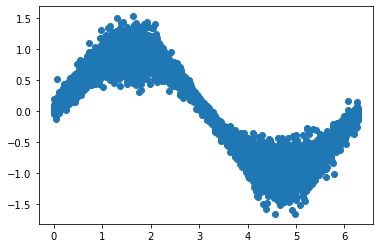

Epoch 45000: -0.00034076880547218025


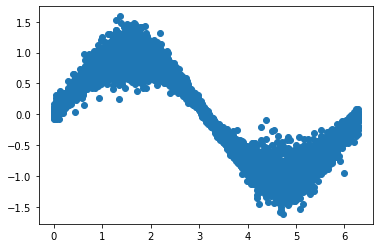

Epoch 46000: -0.0008309329859912395


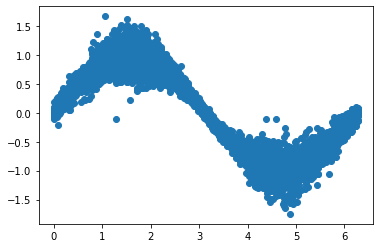

Epoch 47000: -3.696761268656701e-06


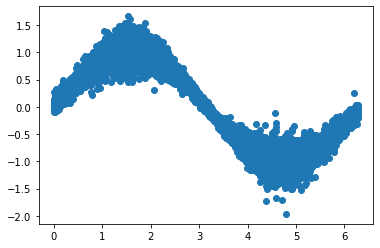

Epoch 48000: -0.0007254224619828165


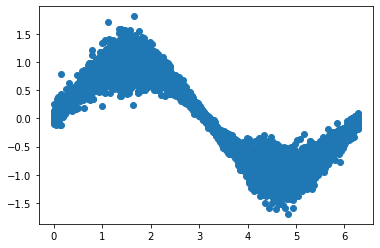

Epoch 49000: -0.0007885307422839105


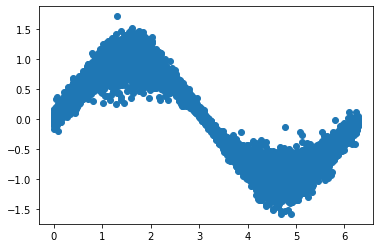

Epoch 50000: -0.0006105332286097109


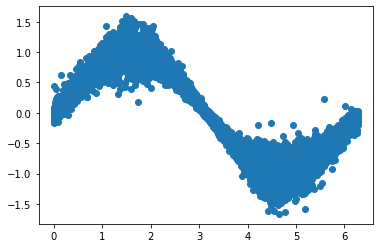

Epoch 51000: -0.0007805215427652001


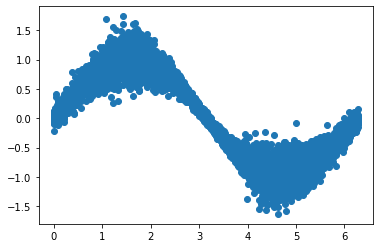

Epoch 52000: -0.00015156925655901432


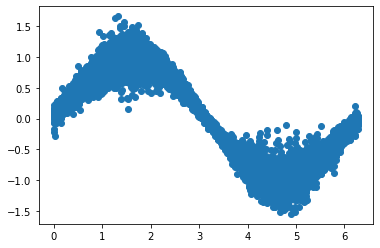

Epoch 53000: -0.0001090010191546753


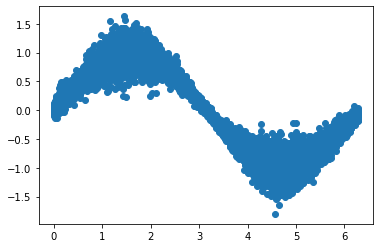

Epoch 54000: -0.0004118534561712295


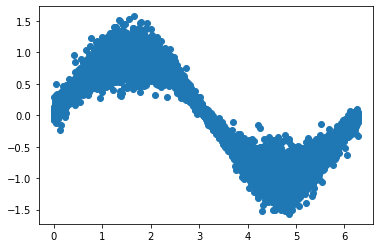

Epoch 55000: -0.0005813063471578062


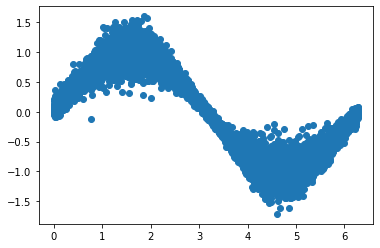

Epoch 56000: -0.000926018285099417


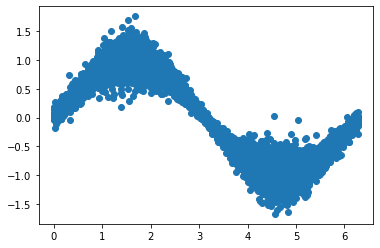

Epoch 57000: 0.00038320437306538224


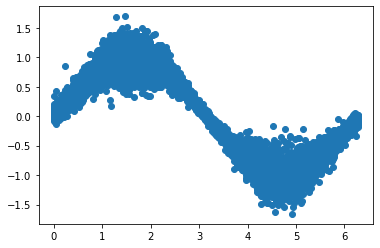

Epoch 58000: 1.8423274013912305e-05


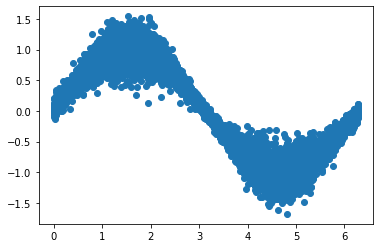

Epoch 59000: -0.0006364135770127177


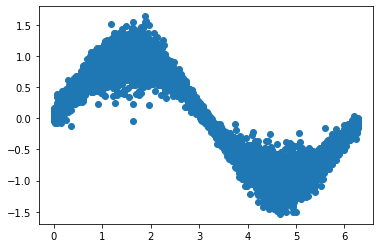

Epoch 60000: -0.0004898544866591692


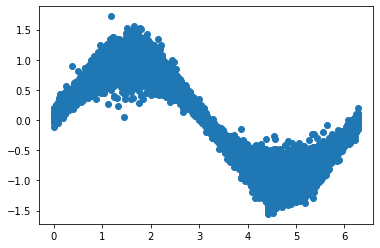

Epoch 61000: -0.0002589202777016908


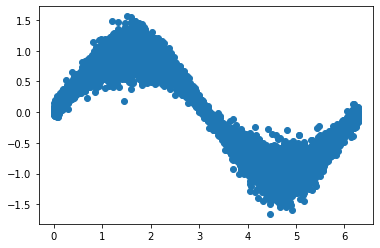

Epoch 62000: -0.0005545005551539361


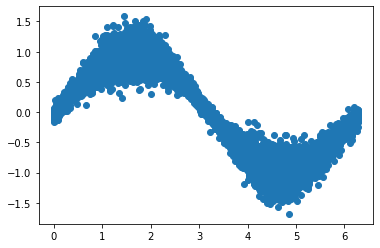

Epoch 63000: -0.00047266684123314917


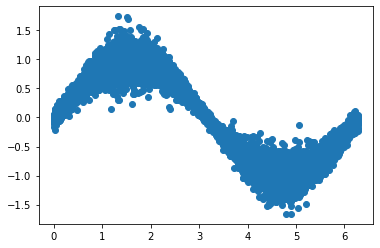

Epoch 64000: -0.0007795483688823879


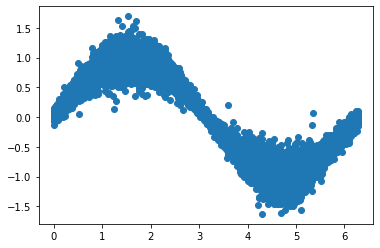

Epoch 65000: -0.0010908824624493718


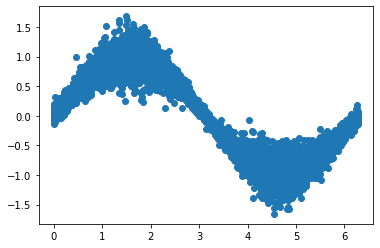

Epoch 66000: -0.0007708632620051503


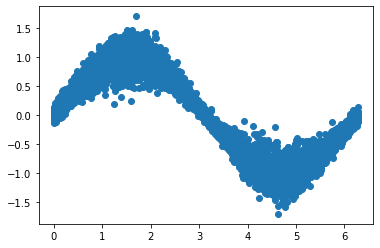

Epoch 67000: -0.000703387544490397


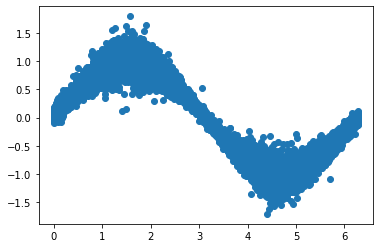

Epoch 68000: -0.000674468872603029


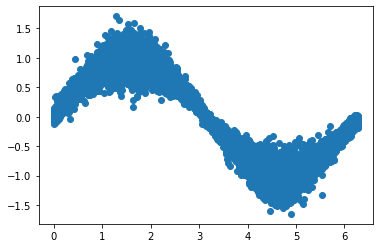

Epoch 69000: -0.0007837294251658022


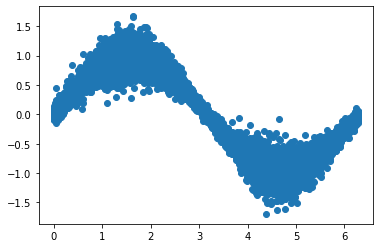

Epoch 70000: -0.0006395209347829223


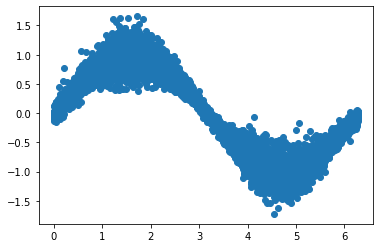

Epoch 71000: -0.0004098137142136693


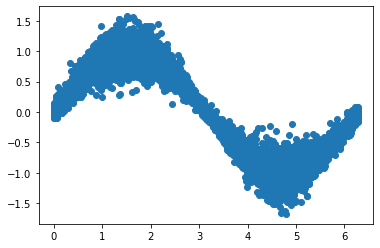

Epoch 72000: -9.135944856097922e-05


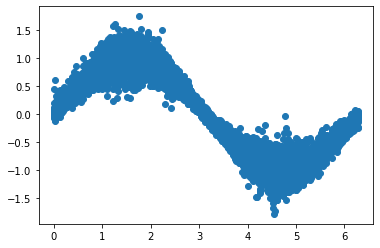

Epoch 73000: 9.972843690775335e-05


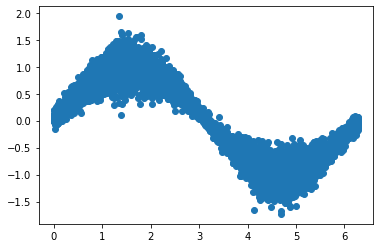

Epoch 74000: -0.0006452458328567445


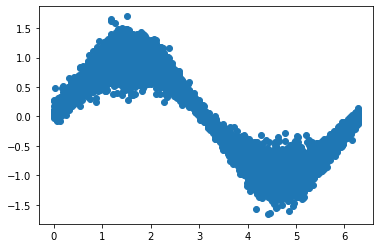

Epoch 75000: -0.0003504696360323578


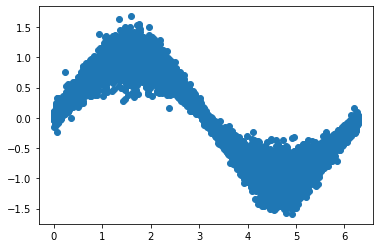

Epoch 76000: -0.0008922163979150355


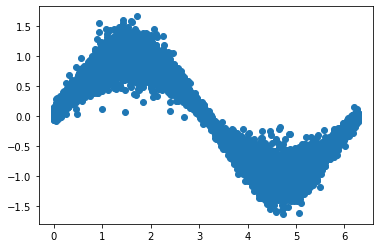

Epoch 77000: -0.00020160597341600806


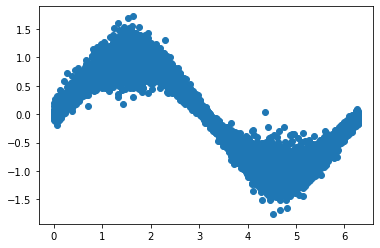

Epoch 78000: -0.00048245638026855886


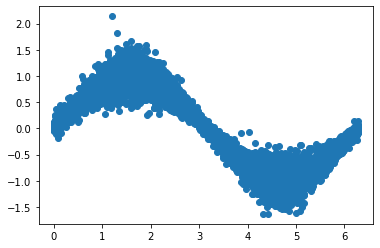

Epoch 79000: -0.0005797736230306327


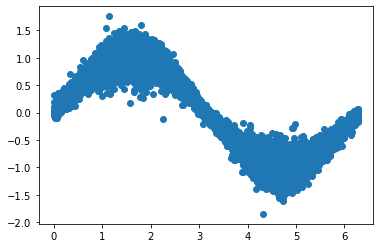

Epoch 80000: -0.0002763310039881617


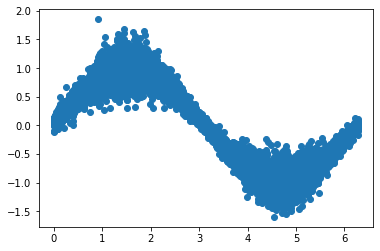

Epoch 81000: -0.00029438987257890403


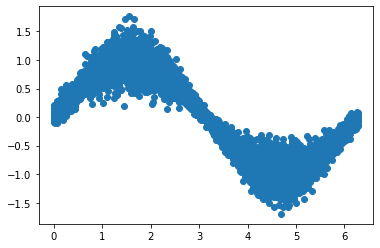

Epoch 82000: 0.00014020052913110703


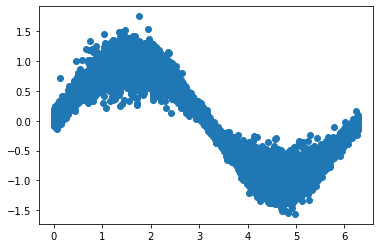

Epoch 83000: 0.0015414160443469882


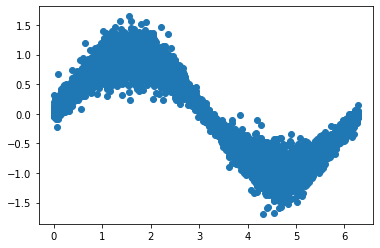

Epoch 84000: -0.00021212623687461019


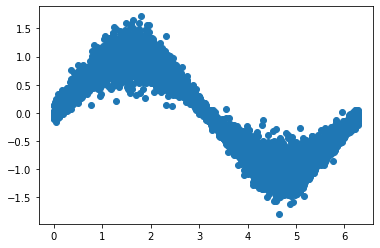

Epoch 85000: -0.0005350693827494979


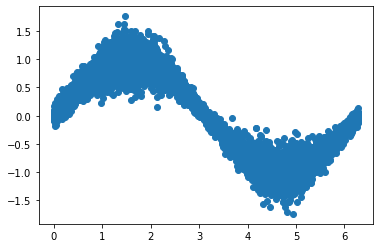

Epoch 86000: -0.00023034855257719755


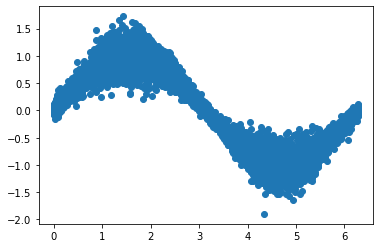

Epoch 87000: 1.0580720299913082e-05


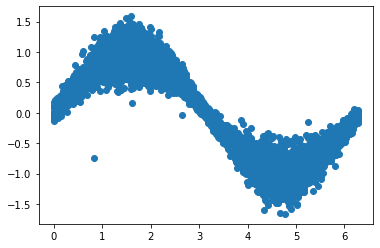

Epoch 88000: -0.0004099427897017449


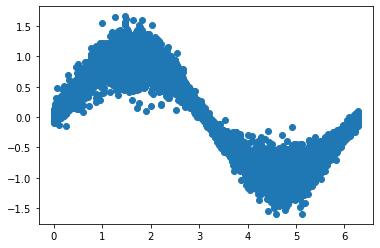

Epoch 89000: -0.00027530320221558213


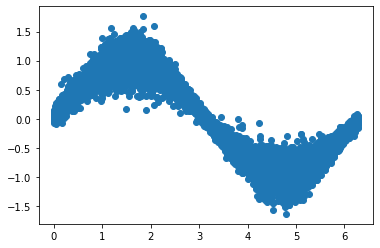

Epoch 90000: -0.0005008908919990063


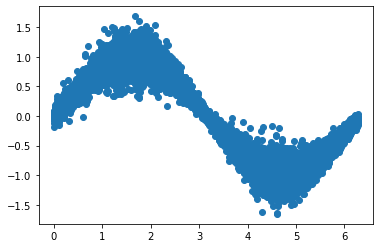

Epoch 91000: -0.00018212884606327862


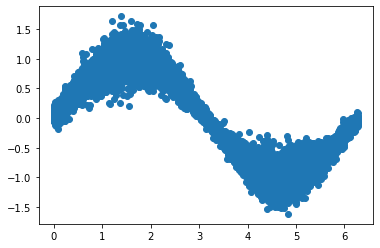

Epoch 92000: -0.0003697456850204617


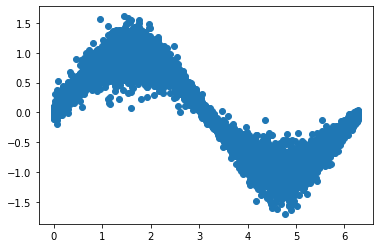

Epoch 93000: -0.0003062486939597875


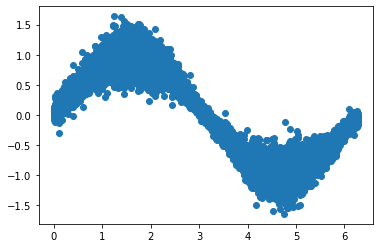

Epoch 94000: -0.00040755770169198513


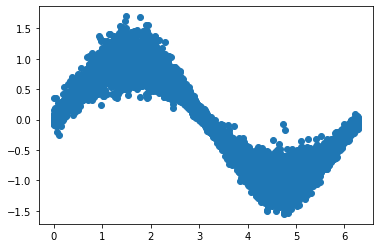

Epoch 95000: -0.0006415757234208286


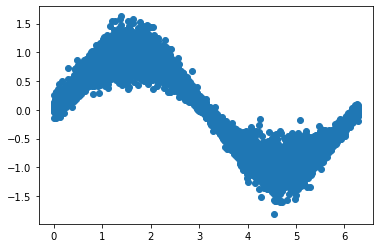

Epoch 96000: -0.0005258813034743071


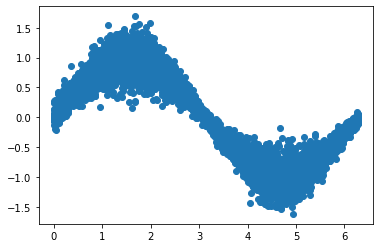

Epoch 97000: -0.00021919672144576907


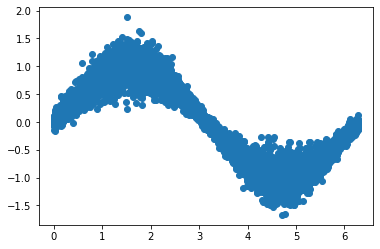

Epoch 98000: -0.0005558880511671305


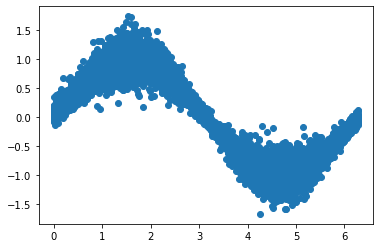

Epoch 99000: -7.067346450639889e-05


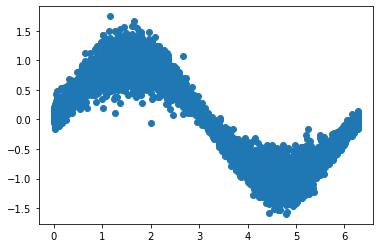

Epoch 100000: -0.00018788308079820126


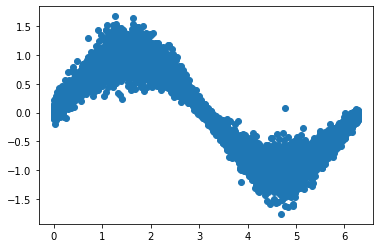

In [47]:
for e in range(epoch): 
  shuffle_idx=np.arange(X.shape[0])
  np.random.shuffle(shuffle_idx)
  epoch_loss=[]
  
  
  optimizer.zero_grad()
  indices=np.random.randint(0, X.shape[0], size=batch_size) 
  batch_x=X[indices,:].to(device)
  
  xmat=model.forwardX(batch_x,indices)
  ymat,zmat=model.backwardYZ(xmat,indices)
  loss_temp=model.Hamcompute(xmat,ymat,zmat)

 # if grad_clip: 
 #     nn.utils.clip_grad_value_(model.parameters(), grad_clip)

  loss_temp.backward()
  optimizer.step()
  epoch_loss.append(loss_temp.cpu().detach().numpy())        
      
  epoch_loss =  np.mean(epoch_loss)
  loss_history.append(epoch_loss)
  
 
  if (e+1) % 1000 == 0:
    print("Epoch {}: {}".format(e+1, epoch_loss))  
  #  W_a=[0.2*torch.tensor(np.random.normal(0,1, (X.shape[0],cfg.dim )),dtype=torch.float32, requires_grad=False).to(device) for i in range(0,cfg.Ntime)]
  #  One can also consider less deeper layers to prevent overfitting. (coordinates, layers)
    v2=model.predict(X.to(device)).cpu().detach().numpy() 
    plt.figure()
    plt.scatter(X.cpu().detach().numpy(),v2)
    plt.show()
  scheduler.step()

In [ ]:
print(e+1)
v3=model.predict_train(X.to(device)).cpu().detach().numpy()
plt.figure()
plt.scatter(X.cpu().detach().numpy(),y)
plt.show()


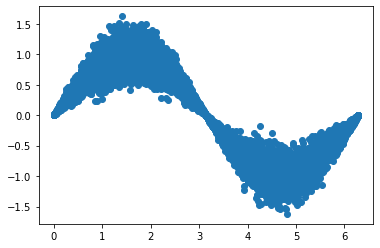

In [41]:
  plt.scatter(X.cpu().detach().numpy(),y)

In [ ]:
y

array([-4.106449  , -0.26177606, -3.875351  , ...,  2.1256015 ,
       -1.6439264 , -2.6802115 ], dtype=float32)

In [ ]:
if (e+1) % 100 == 0:
    print("Epoch {}: {}".format(e+1, epoch_loss))  
  #  W_a=[0.2*torch.tensor(np.random.normal(0,1, (X.shape[0],cfg.dim )),dtype=torch.float32, requires_grad=False).to(device) for i in range(0,cfg.Ntime)]
    v2=model.predict(X.to(device)).cpu().detach().numpy() 
    plt.figure()
    plt.scatter(X.cpu().detach().numpy(),v2)
    plt.show()